<a href="https://colab.research.google.com/github/nghiagithub318/image-captioning-with-Resnet18-and-transformer-decoder/blob/main/image_captioning_convert_to_vietnamese.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import library

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision
import torchvision.transforms as transforms
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
pd.set_option('display.max_colwidth', None)
from tqdm import tqdm
import pickle 
import random

In [ ]:
from google.colab import drive

drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


# Download dataset

In [ ]:
# Download image files
import os
import tensorflow as tf

image_folder = '/train2017/'
if not os.path.exists(os.path.abspath('.') + image_folder):
  image_zip = tf.keras.utils.get_file('train2017.zip',
                                      cache_subdir=os.path.abspath('.'),
                                      origin='http://images.cocodataset.org/zips/train2017.zip',
                                      extract=True)
  PATH = os.path.dirname(image_zip) + image_folder
  os.remove(image_zip)
else:
  PATH = os.path.abspath('.') + image_folder

In [ ]:
import json

annotation_file = '/content/drive/MyDrive/VinBigData/Model/Khong_Tung/UIT-ViIC/uitviic_captions_train2017.json'

with open(annotation_file, 'r') as f:
    annotations = json.load(f)

annotation_val_file = '/content/drive/MyDrive/VinBigData/Model/Khong_Tung/UIT-ViIC/uitviic_captions_val2017.json'

with open(annotation_val_file, 'r') as f:
    annotations_val = json.load(f)

annotation_test_file = '/content/drive/MyDrive/VinBigData/Model/Khong_Tung/UIT-ViIC/uitviic_captions_test2017.json'

with open(annotation_test_file, 'r') as f:
    annotations_test = json.load(f)

In [ ]:
annotations['images'][:1]


[{'license': 2,
  'file_name': '000000535668.jpg',
  'coco_url': 'http://images.cocodataset.org/train2017/000000535668.jpg',
  'height': 426,
  'width': 640,
  'date_captured': '2013-11-19 18:06:56',
  'flickr_url': 'http://farm4.staticflickr.com/3061/2442277392_49eb08cb2f_z.jpg',
  'id': 535668}]

In [ ]:
annotations['annotations'][:1]


[{'image_id': 157656,
  'caption': 'Người đàn ông đang đánh tennis ngoài sân.',
  'id': 4990}]

# Group all captions together having the same image ID.


In [ ]:
import collections

# Group all captions together having the same image ID.
image_path_to_caption = collections.defaultdict(list)
for val in annotations['annotations']:
  caption = f"<start> {val['caption']} <end>"
  # image_path = PATH + 'COCO_train2017_' + '%012d.jpg' % (val['image_id'])
  image_path = PATH + '%012d.jpg' % (val['image_id'])
  image_path_to_caption[image_path].append(caption)

In [ ]:
# Group all captions together having the same image ID.
image_path_to_caption_val = collections.defaultdict(list)
for val in annotations_val['annotations']:
  caption = f"<start> {val['caption']} <end>"
  # image_path = PATH + 'COCO_train2017_' + '%012d.jpg' % (val['image_id'])
  image_path = PATH + '%012d.jpg' % (val['image_id'])
  image_path_to_caption_val[image_path].append(caption)

In [ ]:
# Group all captions together having the same image ID.
image_path_to_caption_test = collections.defaultdict(list)
for val in annotations_test['annotations']:
  caption = f"<start> {val['caption']} <end>"
  # image_path = PATH + 'COCO_train2017_' + '%012d.jpg' % (val['image_id'])
  image_path = PATH + '%012d.jpg' % (val['image_id'])
  image_path_to_caption_test[image_path].append(caption)

In [ ]:
# image_path_to_caption_test
# path ==> caption
#  {'/content/train2017/000000205086.jpg': ['<start> Một cậu bé đang chống đẩy trên quả banh. <end>',
#               '<start> Một cậu bé đang chống đầu lên quả bóng đá hít đất. <end>',
#               '<start> Một cậu bé đang hít đất đầu trên quả banh trên cỏ. <end>',

# convert to dataframe

In [ ]:
df_train = (pd.DataFrame.from_dict(image_path_to_caption, orient='index').T
   .melt(var_name='image', value_name='caption')
   .dropna(subset=['caption'])
  ) 
df_val = (pd.DataFrame.from_dict(image_path_to_caption_val, orient='index').T
   .melt(var_name='image', value_name='caption')
   .dropna(subset=['caption'])
  ) 

In [ ]:
df_train.head()

,image,caption
0,/content/train2017/000000157656.jpg,<start> Người đàn ông đang đánh tennis ngoài sân. <end>
1,/content/train2017/000000157656.jpg,<start> Một vận động viên tennis đang vung vợt đánh bóng. <end>
2,/content/train2017/000000157656.jpg,<start> Một cầu thủ tennis đang vung vợt tennis đỡ bóng. <end>
3,/content/train2017/000000157656.jpg,<start> Người đàn ông đang đứng ngoài biên cầm vợt sẵn sàng đỡ bóng. <end>
4,/content/train2017/000000157656.jpg,<start> Vận động viên tennis nam đang trong tư thế chuẩn bị đỡ bóng. <end>


In [ ]:
df_test = (pd.DataFrame.from_dict(image_path_to_caption_val, orient='index').T
   .melt(var_name='image', value_name='caption')
   .dropna(subset=['caption'])
  ) 
df_test.head()

,image,caption
0,/content/train2017/000000490875.jpg,<start> Hình ảnh một trận đấu tennis đang diễn ra <end>
1,/content/train2017/000000490875.jpg,<start> Hai cầu thủ tennis đang thi đấu trên sân <end>
2,/content/train2017/000000490875.jpg,<start> Hai cầu thủ tennis đan thi đấu trước nhiều người quan sát <end>
3,/content/train2017/000000490875.jpg,<start> Trận tennis đant diễn ra trước nhiều người quan sát <end>
4,/content/train2017/000000490875.jpg,<start> Trận tennis đang diễn ra với hai cầu thủ đang thi đấu <end>


In [ ]:
image_paths = list(image_path_to_caption.keys())
random.shuffle(image_paths)

# Select the first 6000 image_paths from the shuffled set.
# Approximately each image id has 5 captions associated with it, so that will
# lead to 30,000 examples.
train_image_paths = image_paths.copy()
print(len(train_image_paths))

2695


In [ ]:
train_image_paths[:5]


['/content/train2017/000000307794.jpg',
 '/content/train2017/000000572505.jpg',
 '/content/train2017/000000069971.jpg',
 '/content/train2017/000000041740.jpg',
 '/content/train2017/000000545334.jpg']

In [ ]:
train_captions = []
img_name_vector = []

for image_path in train_image_paths:
  caption_list = image_path_to_caption[image_path]
  train_captions.extend(caption_list)
  # print(caption_list)
  img_name_vector.extend([image_path] * len(caption_list))
  # print(img_name_vector)

In [ ]:
print(len(train_captions))
print(len(img_name_vector))

13481
13481


# Import data

# show image

In [ ]:
# cap['image'].iloc[1]

In [ ]:
cap = pd.concat([df_train,df_val ,df_test])

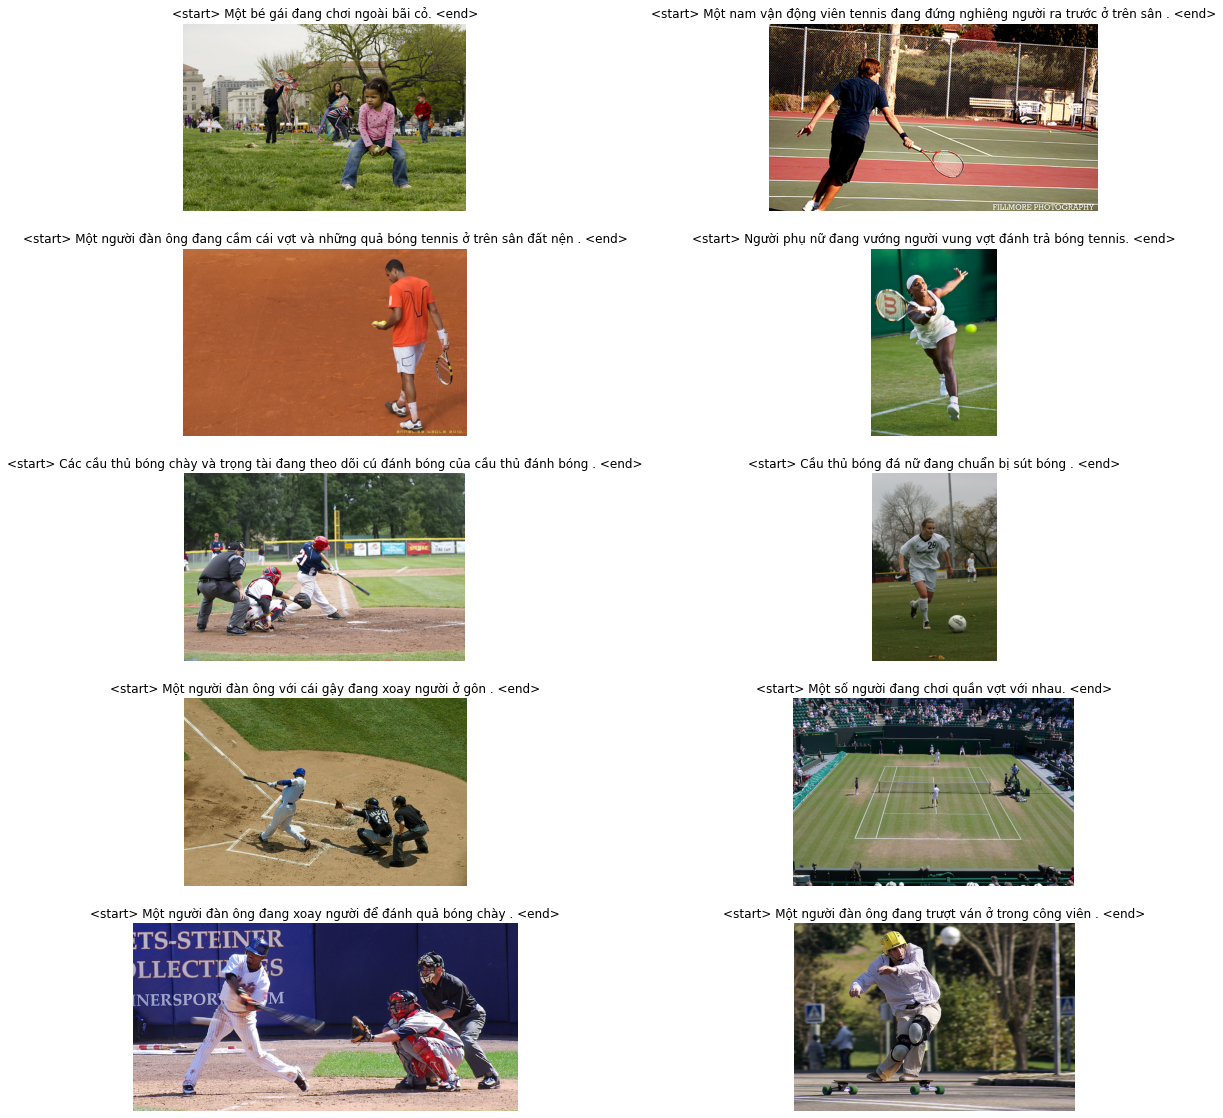

In [ ]:
import cv2
import glob
figure = plt.figure(figsize = (20,20))
for i in range(10):
  plt.subplot(5,2,i+1)
  idx = np.random.randint(0,1000)
  images = cv2.imread(cap['image'].iloc[idx])
  plt.imshow(cv2.cvtColor(images, cv2.COLOR_BGR2RGB))
  plt.axis('off')
  plt.title(df_train['caption'].iloc[idx])
plt.show()

# Preprocessing
1. lower case and remove word not isalpha split 
2. padding 

In [ ]:
def remove_1_length_word(x):
  list = []
  for i in x:
    if len(i)> 1:
      list.append(i)
  return list

In [ ]:
import re
def standardize(inputs):
  inputs = inputs.lower()
  # re.sub(r'\b\S*[AĂÂÁẮẤÀẰẦẢẲẨÃẴẪẠẶẬĐEÊÉẾÈỀẺỂẼỄẸỆIÍÌỈĨỊOÔƠÓỐỚÒỒỜỎỔỞÕỖỠỌỘỢUƯÚỨÙỪỦỬŨỮỤỰYÝỲỶỸỴAĂÂÁẮẤÀẰẦẢẲẨÃẴẪẠẶẬĐEÊÉẾÈỀẺỂẼỄẸỆIÍÌỈĨỊOÔƠÓỐỚÒỒỜỎỔỞÕỖỠỌỘỢUƯÚỨÙỪỦỬŨỮỤỰYÝỲỶỸỴAĂÂÁẮẤÀẰẦẢẲẨÃẴẪẠẶẬĐEÊÉẾÈỀẺỂẼỄẸỆIÍÌỈĨỊOÔƠÓỐỚÒỒỜỎỔỞÕỖỠỌỘỢUƯÚỨÙỪỦỬŨỮỤỰYÝỲỶỸỴAĂÂÁẮẤÀẰẦẢẲẨÃẴẪẠẶẬĐEÊÉẾÈỀẺỂẼỄẸỆIÍÌỈĨỊOÔƠÓỐỚÒỒỜỎỔỞÕỖỠỌỘỢUƯÚỨÙỪỦỬŨỮỤỰYÝỲỶỸỴAĂÂÁẮẤÀẰẦẢẲẨÃẴẪẠẶẬĐEÊÉẾÈỀẺỂẼỄẸỆIÍÌỈĨỊOÔƠÓỐỚÒỒỜỎỔỞÕỖỠỌỘỢUƯÚỨÙỪỦỬŨỮỤỰYÝỲỶỸỴAĂÂÁẮẤÀẰẦẢẲẨÃẴẪẠẶẬĐEÊÉẾÈỀẺỂẼỄẸỆIÍÌỈĨỊOÔƠÓỐỚÒỒỜỎỔỞÕỖỠỌỘỢUƯÚỨÙỪỦỬŨỮỤỰYÝỲỶỸỴA-Z]+\S*\b'
  inputs = re.sub(r'\.!?( *)', ' ', inputs)
  inputs = re.sub(r'[0 - 9]', ' ', inputs)

  return inputs
  

In [ ]:
# df['caption_clean'] = df['caption'].apply(lambda x:  [i.lower() for i in x.split(' ')] )
df = cap.copy()
df['caption_clean'] = df['caption'].apply(standardize)
df['caption_clean'] = df['caption_clean'].apply(lambda x:  [i.lower() for i in x.split(' ')] )
df['caption_clean'] = df['caption_clean'].apply(remove_1_length_word)
df['lens'] = df.caption_clean.apply(lambda x: len(x))
df.head(2)

,image,caption,caption_clean,lens
0,/content/train2017/000000157656.jpg,<start> Người đàn ông đang đánh tennis ngoài sân. <end>,"[<start>, người, đàn, ông, đang, đánh, tennis, ngoài, sân, <end>]",10
1,/content/train2017/000000157656.jpg,<start> Một vận động viên tennis đang vung vợt đánh bóng. <end>,"[<start>, một, vận, động, viên, tennis, đang, vung, vợt, đánh, bóng, <end>]",12


In [ ]:
max_sequence_len = max(df.lens)
max_sequence_len

35

In [ ]:
pad = '<pad>'
df['caption_clean'] = df.caption_clean.apply(lambda x: x + (max_sequence_len - len(x)) * [pad])
df = df.drop(labels = 'lens', axis = 1)
df.head(2)

,image,caption,caption_clean
0,/content/train2017/000000157656.jpg,<start> Người đàn ông đang đánh tennis ngoài sân. <end>,"[<start>, người, đàn, ông, đang, đánh, tennis, ngoài, sân, <end>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>]"
1,/content/train2017/000000157656.jpg,<start> Một vận động viên tennis đang vung vợt đánh bóng. <end>,"[<start>, một, vận, động, viên, tennis, đang, vung, vợt, đánh, bóng, <end>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>]"


## Create dictionary


In [ ]:
world_dict = df['caption_clean'].apply(lambda x: ' '.join(x)).str.cat(sep = ' ').split(' ')
len(world_dict)

795235

In [ ]:
from collections import Counter
world_dict = Counter(world_dict)


In [ ]:
world_dict = sorted(world_dict,key = world_dict.get,reverse = True)
print(world_dict)

['<pad>', '<start>', '<end>', 'bóng', 'đang', 'tennis', 'người', 'trên', 'một', 'sân', 'đánh', 'chày', 'thủ', 'cầu', 'ông', 'đàn', 'vợt', 'động', 'quả', 'viên', 'vận', 'cầm', 'nữ', 'chơi', 'để', 'đấu', 'thi', 'nam', 'áo', 'gậy', 'đứng', 'bị', 'chuẩn', 'phụ', 'đá', 'ném', 'bé', 'những', 'và', 'vung', 'trẻ', 'hai', 'đứa', 'lên', 'trong', 'cậu', 'của', 'các', 'đỡ', 'tay', 'trận', 'trắng', 'với', 'trước', 'ngoài', 'theo', 'phía', 'ra', 'bắt', 'tập', 'cao', 'cỏ', 'luyện', 'về', 'hình', 'dõi', 'ảnh', 'xoay', 'nhảy', 'diễn', 'con', 'cô', 'dùng', 'phát', 'trả', 'cái', 'cú', 'khán', 'tranh', 'giơ', 'sát', 'giả', 'xanh', 'cùng', 'cạnh', 'quan', 'đen', 'găng', 'nhau', 'chạy', 'bước', 'đưa', 'đội', 'trời', 'nhà', 'đỏ', 'mặc', 'số', 'sau', 'chân', 'tới', 'thực', 'hiện', 'vào', 'nhóm', 'bằng', 'tài', 'trọng', 'bay', 'chó', 'chấp', 'dưới', 'đông', 'tác', 'ngồi', 'đeo', 'giao', 'khi', 'gôn', 'gái', 'rổ', 'đi', 'môn', 'nghiêng', 'màu', 'đất', 'sút', 'vừa', 'thành', 'biển', 'đường', 'đảo', 'bãi', 'ba', 

In [ ]:
word_to_idx = {word:idx for (idx,word) in enumerate(world_dict)}
idx_to_word = {idx:word for (idx,word) in enumerate(world_dict)}


In [ ]:
#vocab size
print(len(word_to_idx))
vocab_size = len(word_to_idx)

1339


In [ ]:
df['token'] = df['caption_clean'].apply(lambda x: [word_to_idx.get(i) for i in x])
df.head(2)

,image,caption,caption_clean,token
0,/content/train2017/000000157656.jpg,<start> Người đàn ông đang đánh tennis ngoài sân. <end>,"[<start>, người, đàn, ông, đang, đánh, tennis, ngoài, sân, <end>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>]","[1, 6, 15, 14, 4, 10, 5, 54, 9, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]"
1,/content/train2017/000000157656.jpg,<start> Một vận động viên tennis đang vung vợt đánh bóng. <end>,"[<start>, một, vận, động, viên, tennis, đang, vung, vợt, đánh, bóng, <end>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>]","[1, 8, 20, 17, 19, 5, 4, 39, 16, 10, 3, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]"


In [ ]:
from sklearn.model_selection import train_test_split
df = df.sort_values('image')
train, test = train_test_split(df, random_state = 42, test_size = 0.2)
print(len(train), train['image'].nunique())
print(len(test), test['image'].nunique())

18176 3616
4545 2633


# Image ==> Resnet==> {imagename : image_emb}

In [ ]:
from PIL import Image
class extractFeatureResnet():
  def __init__(self,data):
    self.data = data
    self.scaler = transforms.Resize([224,224])
    self.normalizer = transforms.Normalize(
        mean  = [0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
    self.transform = transforms.ToTensor()
  def __len__(self):
    return len(self.data)

  def __getitem__(self,idx):
    #take image from file image_path
    # print('check 1 ')
    image_name = self.data.iloc[idx]['image']
    # print('check 2 ')
    img = Image.open(image_name).convert('RGB')
    img =  self.normalizer(self.transform(( self.scaler(img))))
    if img.shape[0] == 1 :
      print(img.shape)
    return image_name, img

# take 1000

In [ ]:
train_unique_image = train[['image']].drop_duplicates()
# train_unique_image = train_unique_image[:1000]
train_extract = extractFeatureResnet(train_unique_image)
train_loader = DataLoader(train_extract, batch_size = 1, shuffle = False)

test_unique_image = test[['image']].drop_duplicates()
# test_unique_image = test_unique_image[:1000]
test_extract = extractFeatureResnet(test_unique_image)
test_loader = DataLoader(test_extract, batch_size = 1, shuffle = False)

In [ ]:
for (image_name, img) in train_loader:
    print(image_name)
    print(img.shape)
    break
    

('/content/train2017/000000579419.jpg',)
torch.Size([1, 3, 224, 224])


In [ ]:
train_unique_image.head() #du lieu idx va image name

,image
3970,/content/train2017/000000579419.jpg
6571,/content/train2017/000000449866.jpg
4368,/content/train2017/000000339611.jpg
3969,/content/train2017/000000009960.jpg
1233,/content/train2017/000000122182.jpg


# Resnet model


In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
resnet18 = torchvision.models.resnet18(weights = torchvision.models.ResNet18_Weights.DEFAULT).to(device)
resnet18.eval()
resnet_18_layer_4 = resnet18._modules.get('layer4')

In [ ]:
def get_vector(t_img):
  my_emb = torch.zeros(1,512,7,7)
  t_img = torch.autograd.Variable(t_img).to(device)
  def hook(model, input, output):

    my_emb.copy_(output.data)
  h = resnet_18_layer_4.register_forward_hook(hook)
  resnet18(t_img)
  h.remove()
  # print(my_emb)
  return my_emb


In [ ]:
img_emb = {image_name[0]: get_vector(image) for image_name, image in tqdm(train_loader) }

100%|██████████| 3616/3616 [00:50<00:00, 72.03it/s]


In [ ]:
img_emb_test = {name[0]:get_vector(img) for name , img in tqdm(test_loader)}
# print(img_emb_test)

100%|██████████| 2633/2633 [00:37<00:00, 71.06it/s]


# Is in

In [ ]:
# train = train[train['image'].isin(img_emb.keys())]
# test = train[train['image'].isin(img_emb_test.keys())]
# print(len(test))
# print(len(train))

In [ ]:
with open('train_img_emb.pkl', 'wb') as f: #wb writing as binary
  pickle.dump(img_emb, f)
with open('valid_img_emb.pkl', 'wb') as f:
  pickle.dump(img_emb_test,f)


In [ ]:
# del img_emb , img_emb_test

# Create dataset for Transformer model

In [ ]:
class image_emb_seq_dataset():
  def __init__(self,data, file_path ):
    self.data = data
    self.emb_dict = pd.read_pickle(file_path)
  def __len__(self):
    return len(self.data)
  def __getitem__(self,idx):
    # print('c1')

    seq = self.data.iloc[idx]['token']
    target = seq[1:] + [0] #teacher forcing
    image_name = self.data.iloc[idx]['image']
    # print('c1')
    # print('image_name',image_name)
    img_emb = self.emb_dict[image_name]
    # print('img_emb :',img_emb.shape)
    # print(img_emb)
    # print('c1')

    #convert image from (1,512,7,7) => (1,49,512)
    img_emb = torch.permute(img_emb, (0,2,3,1))
    img_emb = img_emb.view(img_emb.size(0),-1,img_emb.size(3))
    return torch.tensor(seq), torch.tensor(target),img_emb

In [ ]:
batch_size = 128
file_path = 'train_img_emb.pkl'
train_image_seq = DataLoader(image_emb_seq_dataset(train,file_path), batch_size = batch_size, shuffle = True)
file_path = 'valid_img_emb.pkl'
test_image_seq = DataLoader(image_emb_seq_dataset(test,file_path), batch_size = batch_size, shuffle = True)


In [ ]:
# for ( seq, target,image) in train_image_seq:
#     print(seq.shape)
#     print(target.shape)
#     print(image.shape)
#     break

# Create transformer model

## Position encoding

In [ ]:
import math
class position_encoding(nn.Module):
  def __init__(self,d_model = 512, max_len = max_sequence_len, dropout = 0.1):
    super().__init__()

    self.dropout = nn.Dropout(dropout)
    
    pe = torch.zeros(max_len , d_model) # (33,512)
    pos = torch.arange(0,max_len).unsqueeze(1) #(33,1)
    div_term = torch.exp(torch.arange(0,d_model, 2 ).float() * (-math.log(10000.0) / d_model) ) #256
    pe[:,::2] = torch.sin(pos * div_term)
    pe[:,1::2] = torch.cos(pos * div_term)
    pe = pe.unsqueeze(0) # (1,32,512)
    # print('pe ' ,pe.shape)
    self.register_buffer('pe', pe)

  def forward(self,x):
    if x.size(0) > self.pe.size(0):
      self.pe = self.pe.repeat(x.size(0),1,1)
    self.pe = self.pe[:x.size(0),:,:]
    return self.dropout(self.pe +x) 


In [ ]:
# temp = torch.randn(32,max_sequence_len,512)
# pos_layer = position_encoding()
# print(pos_layer(temp).shape)

# Transformer Decoder

In [ ]:
class Imagecaptionmodel(nn.Module):
  def __init__(self , vocab_size = vocab_size, embedding_size = 512, max_len =max_sequence_len  , n_head = 16, num_decoder_layer = 4):
    super().__init__()
    self.position_encoding =  position_encoding(d_model = embedding_size)

    self.transformer_decoder_layer  = nn.TransformerDecoderLayer(d_model = embedding_size, nhead = n_head)
    self.transformer_decoder = nn.TransformerDecoder(self.transformer_decoder_layer,num_layers = num_decoder_layer )
    self.embedding = nn.Embedding(vocab_size, embedding_size)
    self.FC = nn.LazyLinear(vocab_size)
    self.initweights()
    self.embedding_size = embedding_size
  def initweights(self):
    self.embedding.weight.data.uniform_(-0.1,0.1)
    self.FC.weight.data.uniform_(-0.1,0.1)
    self.FC.bias.data.zero_()
  def create_mask(self, seq):
      'create mask for mask attention'
      attention_mask  = torch.ones(seq.size(1), seq.size(1))
      # print('attention_mask ',attention_mask.shape)
      attention_mask  = torch.tril(attention_mask)
      attention_mask = attention_mask.masked_fill(attention_mask == 0 , float('-inf')).masked_fill(attention_mask == 1, 0)

      pad_mask = seq.masked_fill(seq == 0 , float(0.0)).masked_fill(seq > 0  , float(1.0)) # 
      pad_mask_bool  = seq == 0 
      return attention_mask, pad_mask ,pad_mask_bool
  def forward(self,seq, image_embedding):
    image_embedding  = image_embedding.permute(1,0,2) # 49,32,512
    # print(image_embedding)
    # print('create_mask ')
    # print('seq', seq.shape)
    x = self.embedding(seq) * math.sqrt(self.embedding_size)
    x = self.position_encoding(x) # 32, 33 512
    x = x.permute(1,0,2) # (seqlen, batchsize, embedding)
    # print('x permute', x.shape)
    # print('image_embedding shape ', image_embedding.shape)
    attention_mask, pad_mask ,pad_mask_bool = self.create_mask(seq)
    attention_mask, pad_mask ,pad_mask_bool = attention_mask.to(device), pad_mask.to(device) ,pad_mask_bool.to(device)
    # print('done embedding x shape ',x.shape )
    # print('attention_mask, pad_mask ,pad_mask_bool' , attention_mask.shape, pad_mask.shape ,pad_mask_bool.shape)
    
    #model nhan vao tgt: (seq_len, batch_size, embddingsize)
    #memory (input_seq_len, batch_size, embeddingsize)
    # tgt_key_padding_mask = (N,T)
    # tgt_mask = (T,T)
    # memory_mask: (T, S)
    x = self.transformer_decoder(memory = image_embedding,
                                 tgt = x , 
                                 tgt_mask = attention_mask,
                                 tgt_key_padding_mask = pad_mask_bool,
                                 ) #(T, N ,E) (33,32,512)
    # print('out transformer :',x.shape)
    out = self.FC(x)
    return out , pad_mask


# Print shape model

In [ ]:
# from torchsummary import summary
# for ( seq, target,image) in train_image_seq:
#     print(seq.shape)
#     image = image.squeeze(1).to(device)
#     seq = seq.to(device)
#     print('image', image.shape)
#     print(torch.max(seq))
#     print(target.shape)
#     print(image.shape)
#     model = Imagecaptionmodel().to(device)
#     print('output shape  :',model(seq,image)[0].shape)
#     # attention_mask, pad_mask ,pad_mask_bool torch.Size([33, 33]) torch.Size([32, 33]) torch.Size([32, 33])
#     # summary(model, seq,image )
#     break

In [ ]:
# model = Imagecaptionmodel()

In [ ]:
# # FloatTensor containing pretrained weights
# weight = torch.FloatTensor([[1, 2.3, 3], [4, 5.1, 6.3]])
# embedding = nn.Embedding(100,10)
# # Get embeddings for index 1
# temp  = torch.randint(32,(32,33))
# input = torch.LongTensor([1])
# embedding(temp).shape

In [ ]:
# del df, cap 

# Train Loop

In [ ]:
EPOCHS = 10
ict_model= Imagecaptionmodel().to(device)
optimizer = torch.optim.Adam(ict_model.parameters(), lr = 0.00008)
criterion = nn.CrossEntropyLoss(reduction = 'none')
min_val_loss = (np.float('Inf'))
# path = '/content/drive/MyDrive/Colab Notebooks/1. Vin Bigdata/Machine_learning_course/Image_captioning/Bestmodel'


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/lazy.py:178: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  """


In [ ]:
# ict_model  = torch.load('Bestmodel')
torch.cuda.empty_cache()

In [ ]:
for epoch in range(1,EPOCHS+1):
    total_loss_epoch_train = 0
    total_loss_epoch_val = 0
    total_words_train = 0
    total_words_val = 0 
    ict_model.train()
    with tqdm(total=len(train_image_seq) , unit = 'batch') as pbar:
      for (seq, target, image) in (train_image_seq):
        optimizer.zero_grad()

        seq , target, image = seq.to(device) , target.to(device), (image.squeeze(1)).to(device)
        out , pad_mask = ict_model(seq, image) # (33,32,10000)
        out = out.permute(1,2,0)
        loss = criterion(out, target) # (32 ,33)
        loss_pad_mask = torch.mul(loss, pad_mask) # (32,33)
        loss_final = loss_pad_mask.sum()  / pad_mask.sum()
        loss_final.backward()
        optimizer.step()
        total_loss_epoch_train += loss_pad_mask.sum().detach().item()
        total_words_train += pad_mask.sum().detach().item()

        pbar.set_description(desc= f'epoch {epoch} loss={total_loss_epoch_train / total_words_train:0.4f}')
        pbar.update(1) 
       # print(total_loss_epoch_train)
       # print(total_words_train)
       #  print('TRAIN EPOCH : {} , Loss : {}'.format(epoch, total_loss_epoch_train / total_words_train))
      total_loss_epoch_train = total_loss_epoch_train / total_words_train
      # print('TRAIN EPOCH : {} , Loss : {}'.format(epoch,total_loss_epoch_train))
    ict_model.eval()
    with torch.no_grad():
      for (seq, target, image) in test_image_seq:
        seq , target, image = seq.to(device) , target.to(device), (image.squeeze(1)).to(device)
        out , pad_mask = ict_model(seq, image) # (33,32,10000)
        out = out.permute(1,2,0)
        loss = criterion(out, target) # (32 ,33)
        loss_pad_mask = torch.mul(loss, pad_mask) # (32,33)
        loss_final = loss_pad_mask.sum()  / pad_mask.sum()
        total_loss_epoch_val += loss_pad_mask.sum().item()
        total_words_val += pad_mask.sum().item()
      total_loss_epoch_val = total_loss_epoch_val / total_words_val
      if min_val_loss > total_loss_epoch_val :
        print('writing model at epoch : ', epoch)
        torch.save(ict_model, './Bestmodel')
        min_val_loss = total_loss_epoch_val
      print('TEST EPOCH : {} , Loss : {}'.format(epoch,total_loss_epoch_val))



epoch 1 loss=0.8018: 100%|██████████| 142/142 [00:23<00:00,  6.09batch/s]


writing model at epoch :  1
TEST EPOCH : 1 , Loss : 0.8967323289934817


epoch 2 loss=0.7532:  26%|██▌       | 37/142 [00:05<00:16,  6.38batch/s]


KeyboardInterrupt: ignored

In [ ]:
# total_loss_epoch_val = 0
# total_words_val = 0 
# with torch.no_grad():
#       for (seq, target, image) in test_image_seq:
#         seq , target, image = seq.to(device) , target.to(device), (image.squeeze(1)).to(device)
#         out , pad_mask = ict_model(seq, image) # (33,32,10000)
#         out = out.permute(1,2,0)
#         loss = criterion(out, target) # (32 ,33)
#         loss_pad_mask = torch.mul(loss, pad_mask) # (32,33)
#         loss_final = loss_pad_mask.sum()  / pad_mask.sum()
#         total_loss_epoch_val += loss_pad_mask.sum().item()
#         total_words_val += pad_mask.sum().item()
#       total_loss_epoch_val = total_loss_epoch_val / total_words_val
#       if min_val_loss > total_loss_epoch_val :
#         print('writing model at epoch : ', epoch)
#         torch.save(ict_model, './Bestmodel')
#         min_val_loss = total_loss_epoch_val
#       print('TEST EPOCH : {} , Loss : {}'.format(epoch,total_loss_epoch_train))

In [ ]:
torch.save(ict_model, './Bestmodel')

In [ ]:
#load model
model_inference = torch.load('Bestmodel')
start = word_to_idx['<start>']
end = word_to_idx['<end>']
pad = word_to_idx['<pad>']
print(start, end, pad)

1 2 0


# Generate caption

In [ ]:
valid_img_emb = pd.read_pickle('valid_img_emb.pkl')

seq :  torch.Size([1, 35])
['một', 'cầu', 'thủ', 'đánh', 'bóng', 'đang', 'xoay', 'người', 'để', 'đánh', 'bóng', '<end>']


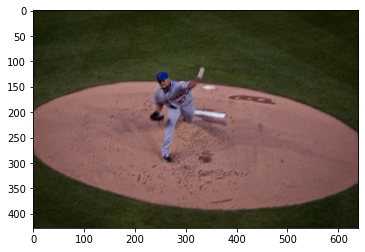

In [ ]:
import random

def gen_caption(k , image_name):
  img = Image.open(image_name)

  plt.imshow(img)
  img_emb = valid_img_emb[image_name] # 1 512 7 7 
  img_emb = img_emb.permute(0,2,3,1) # 1 7 7 512
  # print(img_emb.shape)
  img_emb = img_emb.reshape(img_emb.size(0), -1, img_emb.size(3))
  # print('c1')
  caption = []
  seq = [pad] * max_sequence_len 
  seq[0] = start
  seq = torch.tensor(seq).squeeze(0).view(1, -1).to(device)
  img_emb = img_emb.to(device)
  print('seq : ',seq.shape)
  # print('img_emb : ',img_emb.shape)
  
  for i in range(0,max_sequence_len-1):
    out , _ = model_inference(seq, img_emb) # 33, 32, 10000
    # print('out :', out.shape)
    pred = out[i, 0, :]
    # print('pred : ', pred.shape)

    # pred = pred.squeeze(1)
    # print('pred : ', pred.shape)
    indicies = torch.topk(pred , k ).indices.tolist()
    # print(indicies)
    values = torch.topk(pred, k).values.tolist()
    # print(values)
    token = random.choices(indicies, values)[0] # 
    seq[:, i+1] = token
    # print('seq' , seq)
    if token == pad:
      break
    word = idx_to_word[token]
    caption.append(word)
    # break
  return caption
print(gen_caption(1,test_unique_image['image'].iloc[np.random.randint(0,1000)]))


# Thay preprocess cua phu
# Mabe cho word to vect
# Load and save model cho vao api cua tung